# Malware Detection in Network Traffic Data

## Введение

Над проектом работают: **Шевцов Владислав**, **Иващенко Дмитрий**.

### Постановка задачи

В данном проекте исследуется датасет [Malware Detection in Network Traffic Data](https://www.kaggle.com/datasets/agungpambudi/network-malware-detection-connection-analysis).

Необходимо построить модель машинного обучения, которая по метаданным каждого сетевого потока классифицирует трафик как "нормальный" и "вредоносный".

### Цели исследования

1. Разведочный анализ и подготовка данных:
	* отобрать ключевой набор признаков
	* обработать пропуски, закодировать категориальные признаки
	* изучить распределения признаков, зависимости и оценить корреляции признаков с целевой переменной
2. Построение и сравнение трёх алгоритмов:
	* логистическая регрессия
	* k-NN
	* XGBoost
3. Оценка качества моделей.
4. Выбор финальной модели и рекомендации.

### О данных

* Каждая строка описывает сетевой поток с более чем 20 атрибутами: IP-адреса и порты, протокол, длительность, счётчики пакетов/байтов, состояние сеанса и др.
* Датасет снабжён двумя уровнями разметки:
	+ `label` — **Benign** или **Malicious** (будет целевой переменной);
	+ `detailed-label` — 10 конкретных подтипов атак (используются лишь для валидации и анализа ошибок, но не для обучения).

## Разведочный анализ данных (EDA)

### Подключение библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns
from tqdm.auto import tqdm
%matplotlib inline

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    "figure.dpi": 300,
})

/home/statprak2025/homework/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Загрузка данных

In [2]:
file_names = ['dataset/CTU-IoT-Malware-Capture-1-1conn.log.labeled.csv',
              'dataset/CTU-IoT-Malware-Capture-35-1conn.log.labeled.csv',
              'dataset/CTU-IoT-Malware-Capture-48-1conn.log.labeled.csv'
]

frames = []
for fname in tqdm(file_names, desc="Чтение CSV"):
    frames.append(pd.read_csv(fname, delimiter='|', low_memory=False))

df = pd.concat(frames, ignore_index=True)

df.shape

Чтение CSV: 100%|██████████| 3/3 [00:42<00:00, 14.07s/it]


(14850873, 23)

### Первичный обзор структуры датасета

In [3]:
display(df.sample(5, random_state=42))

df.info(verbose=True)

ts                 uid      id.orig_h  id.orig_p  \
4589594   1.545441e+09  Cq7fYO2q50cZLRIYjk  192.168.1.196    40928.0   
3602070   1.545430e+09  Co778n4WWYFd1JiAvb  192.168.1.196    49098.0   
2526819   1.545419e+09  Cbx6kV17WhiooUBJQg  192.168.1.196    50260.0   
11474804  1.551378e+09  C8as5i2xSfS4ARqcuj  192.168.1.200    51594.0   
5486125   1.545450e+09  CoHCY04361ONeJGDK6  192.168.1.196    46472.0   

                id.resp_h  id.resp_p proto service  duration orig_bytes  ...  \
4589594   125.160.184.151       23.0   tcp       -         -          -  ...   
3602070    84.150.201.146       23.0   tcp       -  3.158983          0  ...   
2526819   158.157.238.194       23.0   tcp       -         -          -  ...   
11474804    147.155.34.92       23.0   tcp       -  3.137735          0  ...   
5486125   189.162.165.237       23.0   tcp       -  3.102712          0  ...   

         local_resp missed_bytes history orig_pkts  orig_ip_bytes resp_pkts  \
4589594           -          0.0       S       1.0           60.0       0.0   
3602070           -          0.0       S       3.0          180.0       0.0   
2526819           -          0.0       S       1.0           60.0       0.0   
11474804          -          0.0       S       6.0          360.0       0.0   
5486125           -          0.0       S       3.0          180.0       0.0   

          resp_ip_bytes  tunnel_parents  \
4589594             0.0               -   
3602070             0.0               -   
2526819             0.0               -   
11474804            0.0               -   
5486125             0.0               -   

                                          label  detailed-label  
4589594                                  Benign               -  
3602070                                  Benign               -  
2526819                                  Benign               -  
11474804  Malicious   PartOfAHorizontalPortScan             NaN  
5486125                                  Benign               -  

[5 rows x 23 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850873 entries, 0 to 14850872
Data columns (total 23 columns):
 #   Column          Dtype  
---  ------          -----  
 0   ts              float64
 1   uid             object 
 2   id.orig_h       object 
 3   id.orig_p       float64
 4   id.resp_h       object 
 5   id.resp_p       float64
 6   proto           object 
 7   service         object 
 8   duration        object 
 9   orig_bytes      object 
 10  resp_bytes      object 
 11  conn_state      object 
 12  local_orig      object 
 13  local_resp      object 
 14  missed_bytes    float64
 15  history         object 
 16  orig_pkts       float64
 17  orig_ip_bytes   float64
 18  resp_pkts       float64
 19  resp_ip_bytes   float64
 20  tunnel_parents  object 
 21  label           object 
 22  detailed-label  object 
dtypes: float64(8), object(15)
memory usage: 2.5+ GB


### Предобработка данных

Начнём с того, что сразу же удалим столбцы, которые вряд ли могут пригодиться, а именно:
* `ts` - временная метка события подключения.
* `uid` - уникальный идентификатор соединения.
* `id.orig_h` - 
* `id.resp_h` - 
* `local_orig` и `local_resp` - указывает, считается ли соединение локальным или нет.
* `missed_bytes` - количество пропущенных байтов в соединении.
* `tunnel_parents` - указывает, является ли это соединение частью туннеля.
* `detailed-label` - более подробное описание или метка соединения.

In [4]:
cols_to_del = [
    'ts',
    'uid',
    'id.orig_h',
    'id.resp_h',
    'local_orig',
    'local_resp',
    'missed_bytes',
    'tunnel_parents',
    'detailed-label'
]

df_copy = df.drop(columns=cols_to_del)

In [5]:
df_copy.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850873 entries, 0 to 14850872
Data columns (total 14 columns):
 #   Column         Non-Null Count     Dtype  
---  ------         --------------     -----  
 0   id.orig_p      14850873 non-null  float64
 1   id.resp_p      14850873 non-null  float64
 2   proto          14850873 non-null  object 
 3   service        14850873 non-null  object 
 4   duration       14850873 non-null  object 
 5   orig_bytes     14850873 non-null  object 
 6   resp_bytes     14850873 non-null  object 
 7   conn_state     14850873 non-null  object 
 8   history        14850873 non-null  object 
 9   orig_pkts      14850873 non-null  float64
 10  orig_ip_bytes  14850873 non-null  float64
 11  resp_pkts      14850873 non-null  float64
 12  resp_ip_bytes  14850873 non-null  float64
 13  label          14850873 non-null  object 
dtypes: float64(6), object(8)
memory usage: 1.5+ GB


Далее наведём порядок по типу данных для каждого столбца:

In [6]:
for col in df_copy.columns:
    print(df_copy[col].value_counts())

id.orig_p
43763.0    399684
3.0         17111
123.0       11682
11.0         4193
41128.0      1037
            ...  
23598.0        23
27470.0        23
62347.0        23
63236.0        22
4057.0         21
Name: count, Length: 65536, dtype: int64
id.resp_p
23.0       11919642
80.0        1111536
992.0       1008358
8080.0       135382
2323.0        88184
             ...   
55979.0           1
19083.0           1
53406.0           1
21292.0           1
58082.0           1
Name: count, Length: 65427, dtype: int64
proto
tcp     14416844
udp       412782
icmp       21247
Name: count, dtype: int64
service
-       14846093
http        3285
dns         1482
ssl            9
dhcp           3
ssh            1
Name: count, dtype: int64
duration
-           5228916
2e-06       1166688
1e-06        273135
5e-06         95036
4e-06         43151
             ...   
3.132791          1
0.151652          1
1.170594          1
0.291072          1
3.281882          1
Name: count, Length: 1016120, dt

In [7]:
df_copy['id.orig_p'] = df_copy['id.orig_p'].astype('int64')

df_copy['id.resp_p'] = df_copy['id.resp_p'].astype('int64')

df_copy['proto'] = df_copy['proto'].astype('string')

df_copy['service'] = df_copy['service'].astype('string')

df_copy['duration'] = df_copy['duration'].astype('string')
df_copy['duration'] = df_copy['duration'].replace('-', '0')
df_copy['duration'] = df_copy['duration'].astype('float64')

df_copy['orig_bytes'] = df_copy['orig_bytes'].astype('string')
df_copy['orig_bytes'] = df_copy['orig_bytes'].replace('-', '0')
df_copy['orig_bytes'] = df_copy['orig_bytes'].astype('int64')

df_copy['resp_bytes'] = df_copy['resp_bytes'].astype('string')
df_copy['resp_bytes'] = df_copy['resp_bytes'].replace('-', '0')
df_copy['resp_bytes'] = df_copy['resp_bytes'].astype('int64')

df_copy['conn_state'] = df_copy['conn_state'].astype('string')

df_copy['history'] = df_copy['history'].astype('string')

df_copy['orig_pkts'] = df_copy['orig_pkts'].astype('int64')

df_copy['orig_ip_bytes'] = df_copy['orig_ip_bytes'].astype('int64')

df_copy['resp_pkts'] = df_copy['resp_pkts'].astype('int64')

df_copy['resp_ip_bytes'] = df_copy['resp_ip_bytes'].astype('int64')

df_copy['label'] = df_copy['label'].astype('string')
df_copy['label'] = df_copy['label'].where(df_copy['label'] == 'Benign', 'Malicious')

Теперь выделим отдельно `label`:

In [8]:
df_label = df_copy[['label']].copy()

Осталось лишь закодировать `proto`, `service`, `conn_state` и `history`. Будем использовать два подхода: `OrdinalEncoder` и `OneHotEncoder`.

In [9]:
cat_cols = ['proto', 'service', 'conn_state', 'history']

In [10]:
# from sklearn.preprocessing import OrdinalEncoder

# df_enc = df_copy.copy()
# df_enc = df_enc.drop(columns=['label'])

# print('Before ordinal encoding:')
# print(df_enc.values[0])
# print(df_enc.shape)

# enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# df_enc[cat_cols] = enc.fit_transform(df_enc[cat_cols])

# print('After ordinal encoding:')
# print(df_enc.values[0])
# print(df_enc.shape)

In [11]:
# from sklearn.preprocessing import OneHotEncoder

# df_ohe = df_copy.copy()
# df_ohe = df_ohe.drop(columns=['label'])

# print('Before one-hot encoding:')
# print(df_ohe.values[0])
# print(df_ohe.shape)

# ohe = OneHotEncoder(handle_unknown='ignore',
#                     sparse_output=False,
#                     dtype='int8',
#                     min_frequency=120,
#                     drop='first'
#       )

# encoded = ohe.fit_transform(df_ohe[cat_cols])

# new_cols = ohe.get_feature_names_out(cat_cols)

# encoded_df = pd.DataFrame(encoded, columns=new_cols, index=df_ohe.index)

# df_ohe = pd.concat([df_ohe.drop(columns=cat_cols), encoded_df], axis=1)

# print('After one-hot encoding:')
# print(df_ohe.values[0])
# print(df_ohe.shape)

Итак, теперь мы имеем:
* `df_copy` - предобработанные данные без кодирования `string` данных и со столбцом `label` (это будет удобно для визуализации).
* `df_enc` - предобработанные данные с `OrdinalEncoder`.
* `df_ohe` - предобработанные данные с `OneHotEncoder`.
* `df_label` - метки.

In [12]:
df_copy.info(show_counts=True)

df_copy.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850873 entries, 0 to 14850872
Data columns (total 14 columns):
 #   Column         Non-Null Count     Dtype  
---  ------         --------------     -----  
 0   id.orig_p      14850873 non-null  int64  
 1   id.resp_p      14850873 non-null  int64  
 2   proto          14850873 non-null  string 
 3   service        14850873 non-null  string 
 4   duration       14850873 non-null  float64
 5   orig_bytes     14850873 non-null  int64  
 6   resp_bytes     14850873 non-null  int64  
 7   conn_state     14850873 non-null  string 
 8   history        14850873 non-null  string 
 9   orig_pkts      14850873 non-null  int64  
 10  orig_ip_bytes  14850873 non-null  int64  
 11  resp_pkts      14850873 non-null  int64  
 12  resp_ip_bytes  14850873 non-null  int64  
 13  label          14850873 non-null  string 
dtypes: float64(1), int64(8), string(5)
memory usage: 1.5 GB


id.orig_p  id.resp_p proto service  duration  orig_bytes  resp_bytes  \
0      51524         23   tcp       -  2.999051           0           0   
1      56305         23   tcp       -  0.000000           0           0   
2      41101         23   tcp       -  0.000000           0           0   
3      60905         23   tcp       -  2.998796           0           0   
4      44301         23   tcp       -  0.000000           0           0   

  conn_state history  orig_pkts  orig_ip_bytes  resp_pkts  resp_ip_bytes  \
0         S0       S          3            180          0              0   
1         S0       S          1             60          0              0   
2         S0       S          1             60          0              0   
3         S0       S          3            180          0              0   
4         S0       S          1             60          0              0   

       label  
0  Malicious  
1  Malicious  
2  Malicious  
3  Malicious  
4  Malicious

### Анализ данных

#### Распределение целевого признака

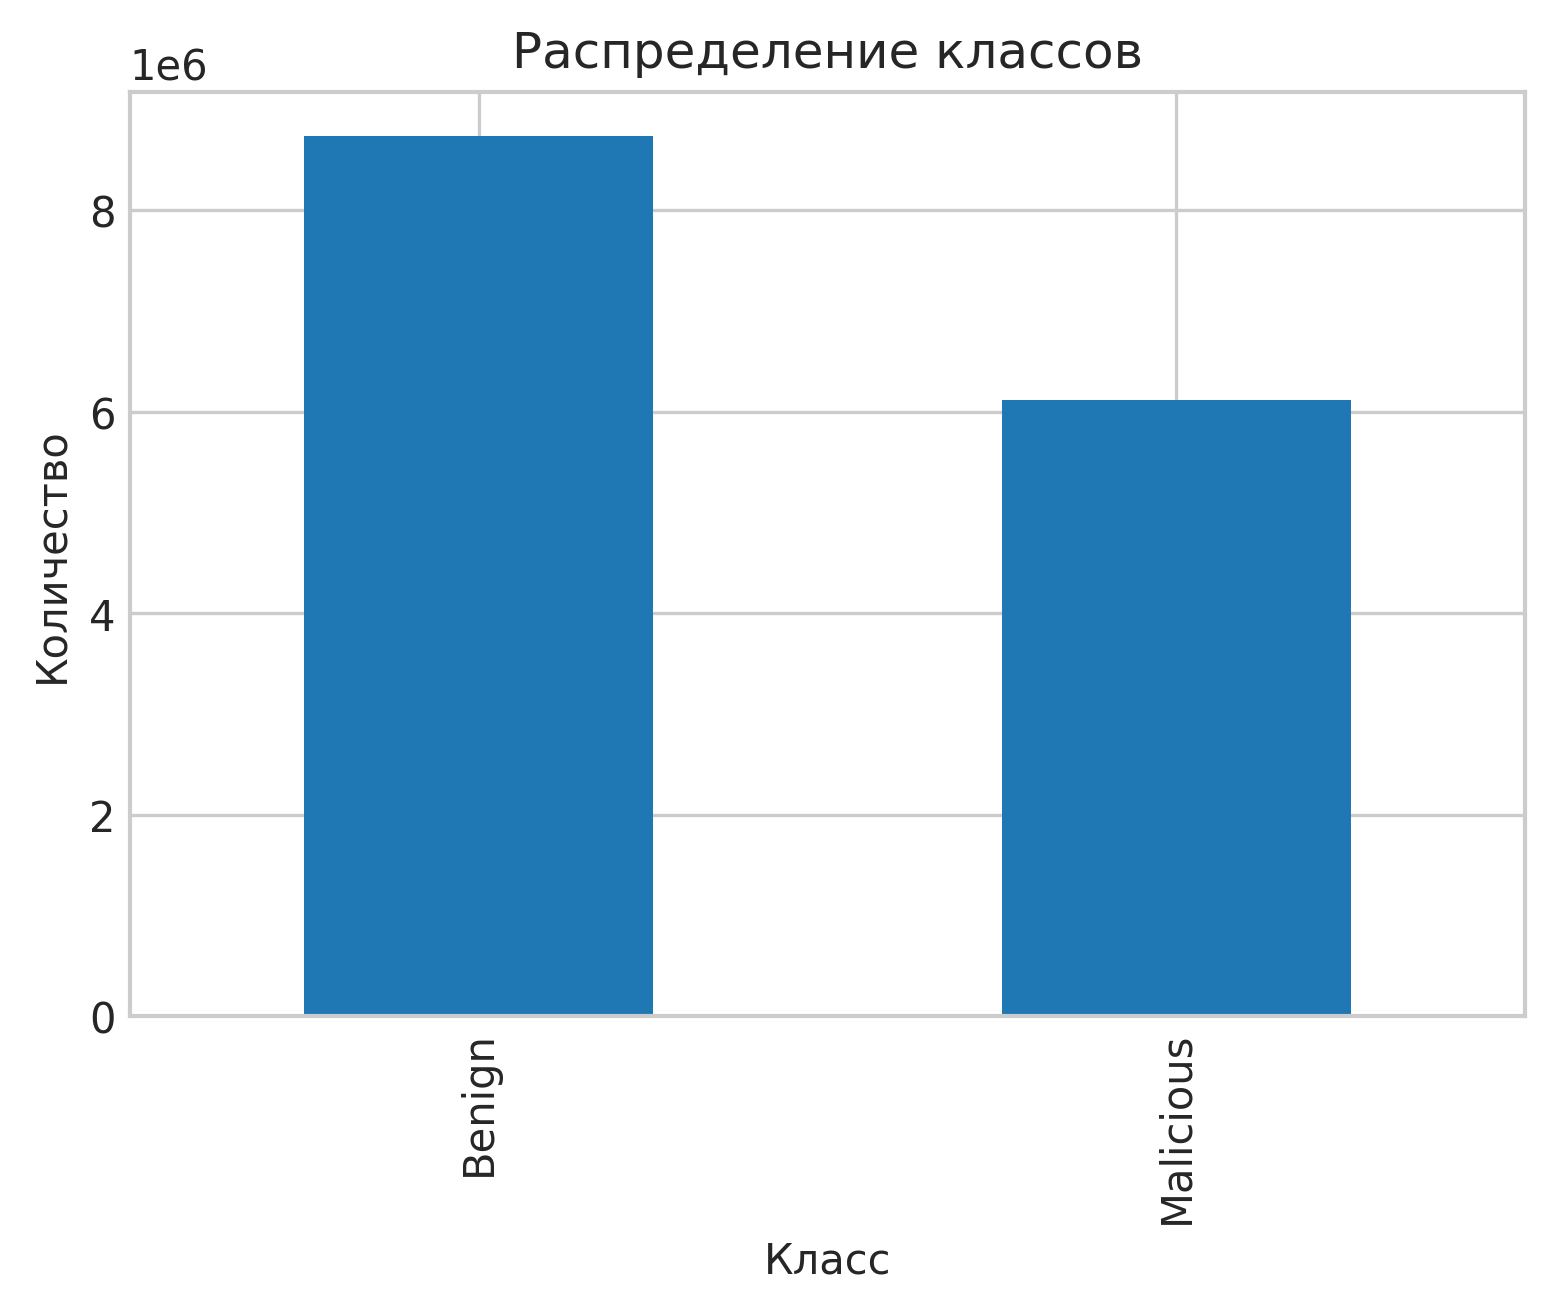

In [13]:
df_label['label'].value_counts().plot(kind='bar', figsize=(6,4))
plt.title('Распределение классов')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.show()

#### Распределения категориальных признаков

In [14]:
cat_cols = ['proto', 'service', 'conn_state', 'history']

TOP_N = 10

count_tables = {}
rate_tables = {}

for col in cat_cols:
    # Берём TOP_N категорий по общему количеству
    top_vals = df_copy[col].value_counts().nlargest(TOP_N).index
    sub = df_copy[df_copy[col].isin(top_vals)]
    
    # Абсолютные частоты
    counts = pd.crosstab(sub[col], sub['label']).reindex(top_vals)
    count_tables[col] = counts
    
    # Доля Malicious
    rates = counts.div(counts.sum(axis=1), axis=0)['Malicious']
    rate_tables[col] = rates

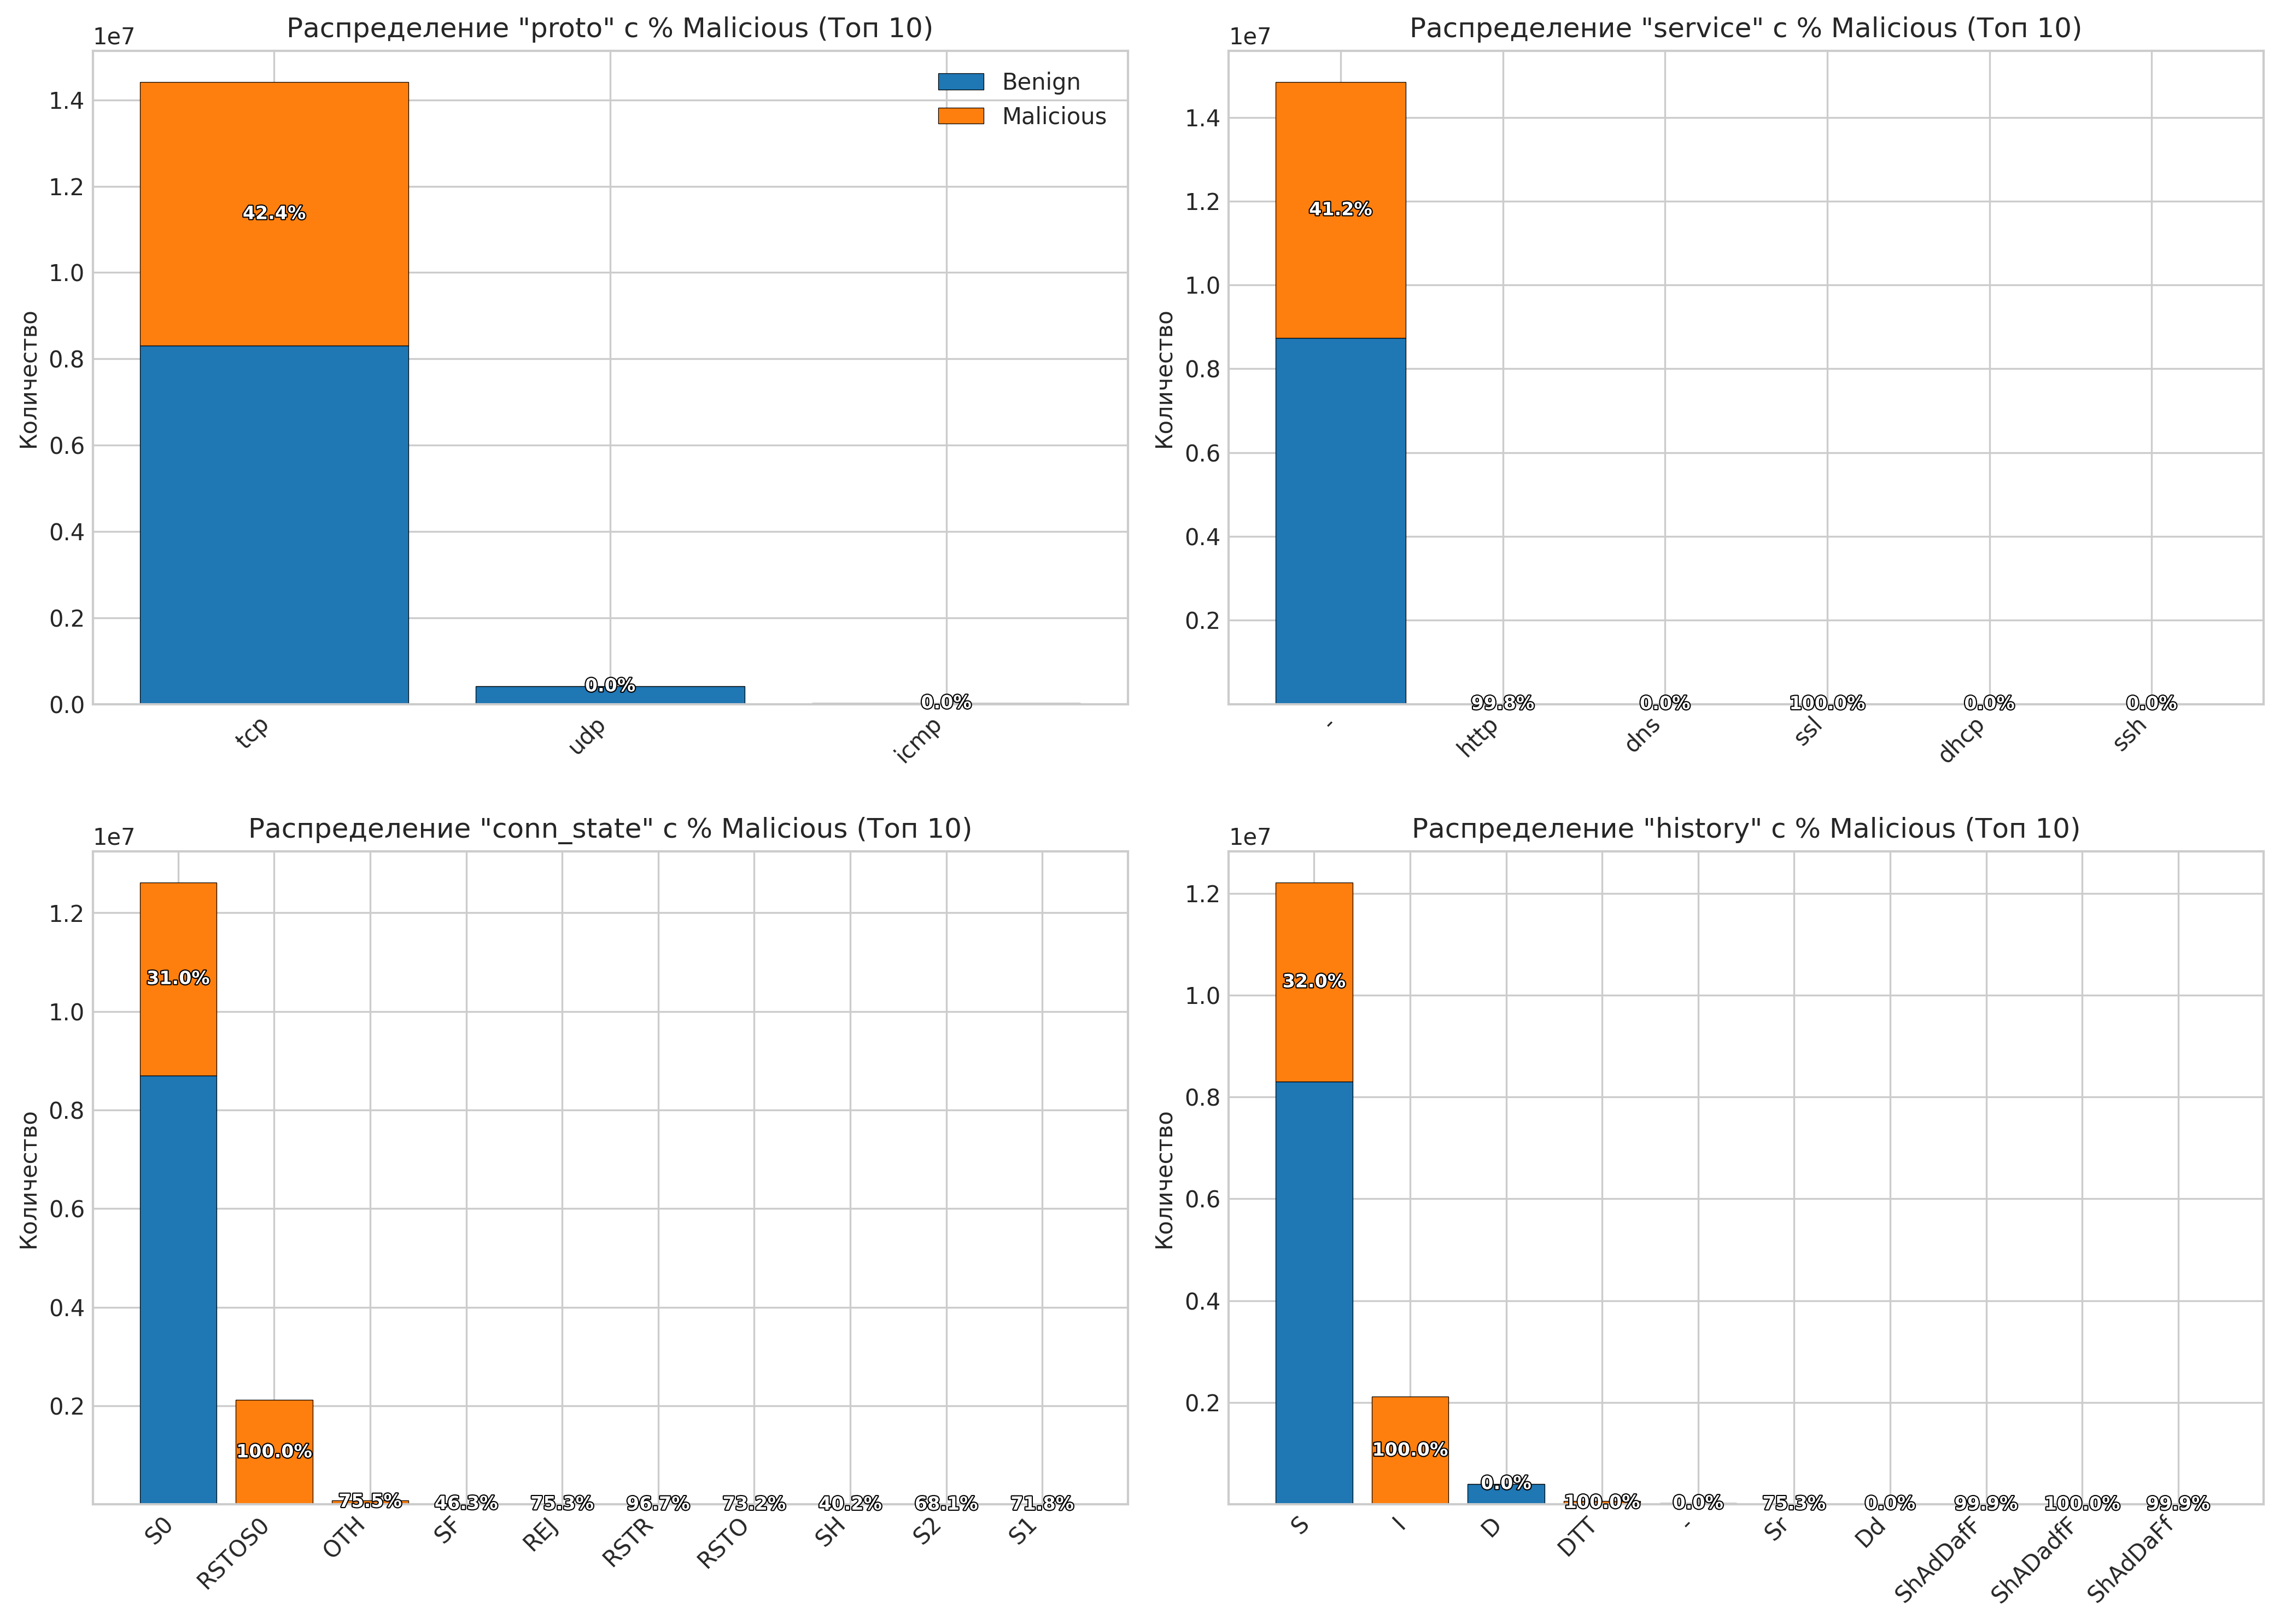

In [15]:
plt.rcParams.update({'font.size': 10})

fig1, axes1 = plt.subplots(2, 2, figsize=(14, 10))
axes1 = axes1.flatten()

for ax, col in zip(axes1, cat_cols):
    counts = count_tables[col]
    x = np.arange(len(counts))

    benign = counts['Benign'].values
    malicious = counts['Malicious'].values

    ax.bar(x, benign, label='Benign', edgecolor='black', linewidth=0.3)
    bars_mal = ax.bar(x, malicious, bottom=benign, label='Malicious', edgecolor='black', linewidth=0.3)

    for idx, bar in enumerate(bars_mal):
        total = benign[idx] + malicious[idx]
        if total == 0:
            continue
        pct = malicious[idx] / total * 100

        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_y() + bar.get_height() / 2,
            f'{pct:.1f}%',
            ha='center', va='center',
            fontsize=8, color='white', weight='bold',
            path_effects=[pe.withStroke(linewidth=1, foreground='black')]
        )

    ax.set_title(f'Распределение "{col}" с % Malicious (Топ {TOP_N})')
    ax.set_xticks(x)
    ax.set_xticklabels(counts.index, rotation=45, ha='right')
    ax.set_ylabel('Количество')

    if col == cat_cols[0]:
        ax.legend()

fig1.tight_layout()

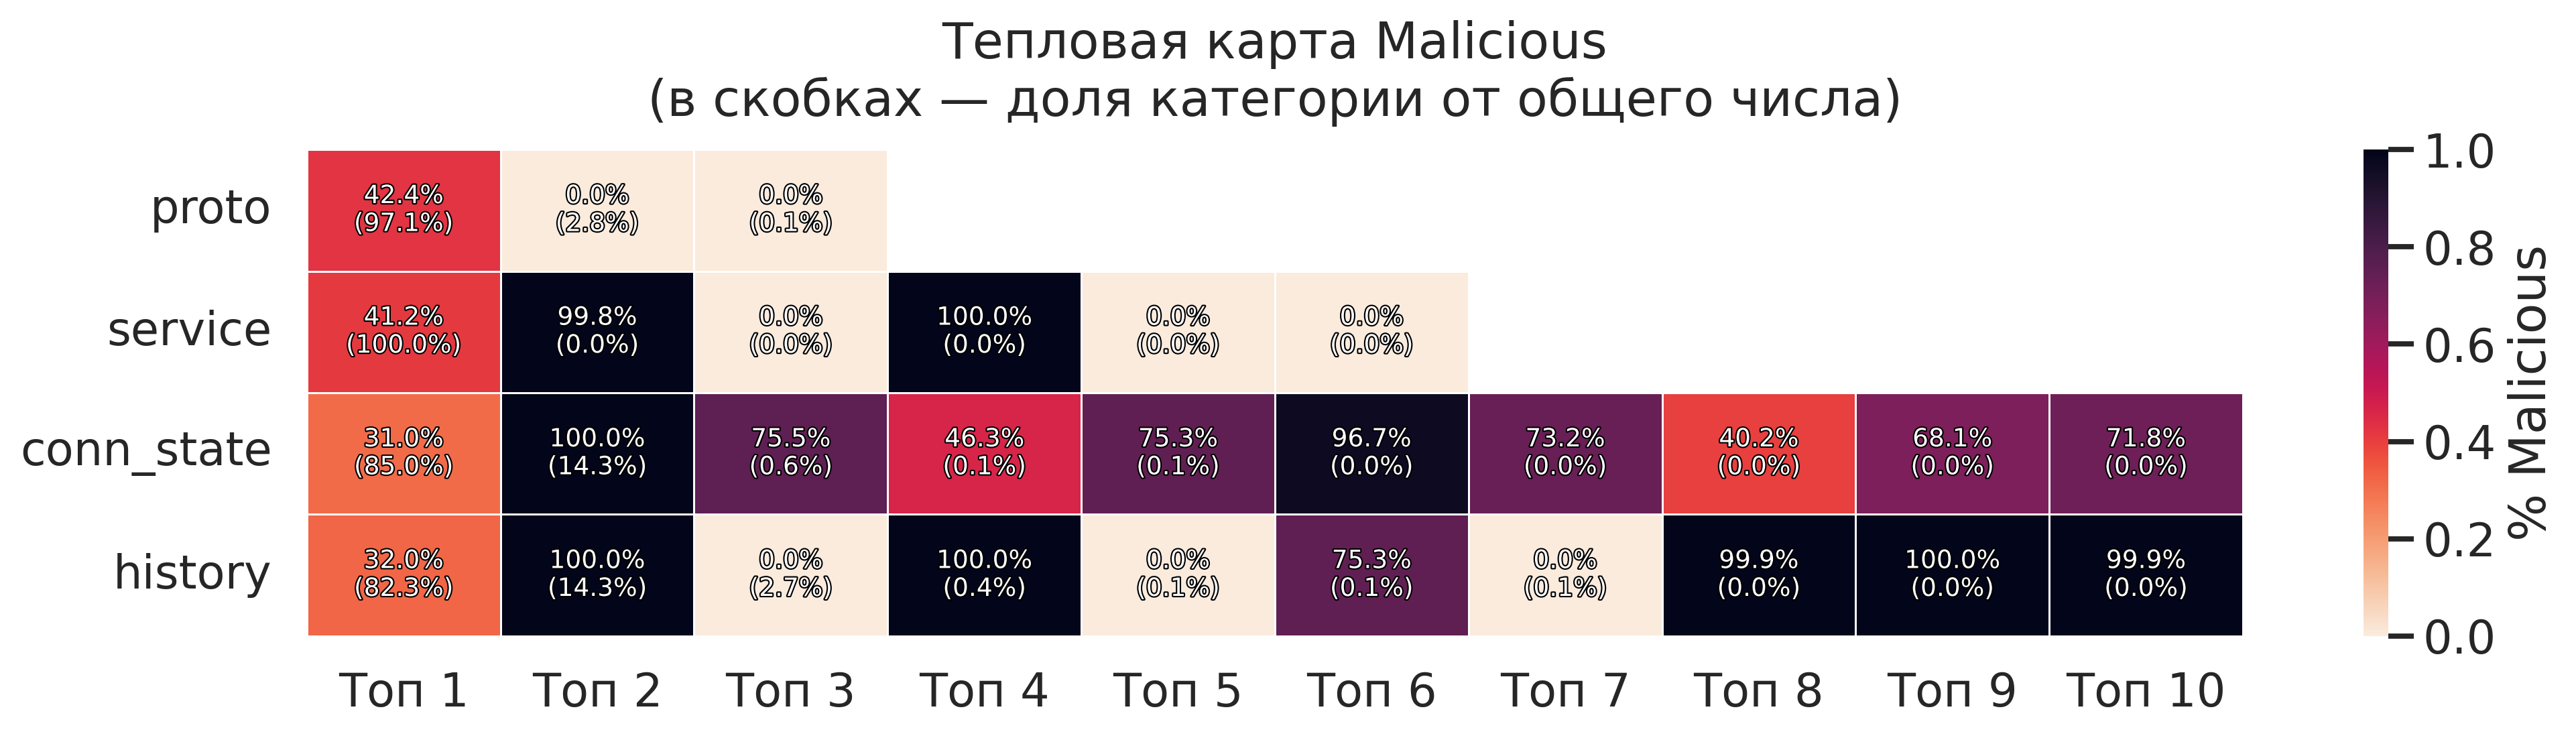

In [16]:
heatmap_df = pd.DataFrame(index=cat_cols, columns=range(TOP_N))
for col in cat_cols:
    rates = rate_tables[col]
    heatmap_df.loc[col, :len(rates)-1] = rates.values
hm = heatmap_df.astype(float)

cs = pd.DataFrame(index=cat_cols, columns=range(TOP_N), dtype=float)
for col in cat_cols:
    total_counts = (count_tables[col]['Benign'] +
                    count_tables[col]['Malicious']).values
    share = total_counts / total_counts.sum() * 100
    cs.loc[col, :len(share)-1] = share.round(1)

annot = pd.DataFrame(index=hm.index, columns=hm.columns, dtype=object)
for r in hm.index:
    for c in hm.columns:
        mal = hm.loc[r, c]
        cnt = cs.loc[r, c]
        if pd.notna(mal) and pd.notna(cnt):
            annot.loc[r, c] = f'{mal*100:.1f}%\n({cnt:.1f}%)'
        else:
            annot.loc[r, c] = ""
            
sns.set_theme(style="white", context="talk")

fig, ax = plt.subplots(figsize=(14, 4))
sns.heatmap(
    hm, cmap="rocket_r", vmin=0, vmax=1,
    linewidths=.6, linecolor="white",
    annot=annot, fmt='',
    annot_kws={
        "fontsize":9, "color":"white", "ha":"center",
        "path_effects":[pe.withStroke(linewidth=1, foreground="black")]
    },
    cbar_kws={"label": "% Malicious"}
)

ax.set_xticklabels([f'Топ {i+1}' for i in range(TOP_N)])
ax.set_title("Тепловая карта Malicious\n(в скобках — доля категории от общего числа)", pad=12)
ax.set_xlabel("")
ax.set_ylabel("")

fig.tight_layout()

#### Распределения числовых признаков

In [17]:
numeric_cols = df_copy.select_dtypes(include=["int64", "float64"]).columns.tolist()

In [18]:
df_copy[numeric_cols].describe().T

count          mean           std  min      25%  \
id.orig_p      14850873.0  4.462183e+04  1.169169e+04  0.0  38310.0   
id.resp_p      14850873.0  1.185472e+03  6.502683e+03  0.0     23.0   
duration       14850873.0  2.119413e+00  2.395311e+01  0.0      0.0   
orig_bytes     14850873.0  1.441985e+08  2.213839e+09  0.0      0.0   
resp_bytes     14850873.0  2.265032e+03  8.246110e+06  0.0      0.0   
orig_pkts      14850873.0  4.165688e+00  2.201146e+03  0.0      1.0   
orig_ip_bytes  14850873.0  1.956520e+02  6.163235e+04  0.0     60.0   
resp_pkts      14850873.0  1.170416e-02  1.462432e+00  0.0      0.0   
resp_ip_bytes  14850873.0  1.179015e+00  3.799511e+02  0.0      0.0   

                        50%           75%           max  
id.orig_p      45418.000000  53369.000000  6.553500e+04  
id.resp_p         23.000000     23.000000  6.553500e+04  
duration           2.493569      3.127227  8.575584e+04  
orig_bytes         0.000000      0.000000  6.620558e+10  
resp_bytes         0.000000      0.000000  3.172051e+10  
orig_pkts          2.000000      3.000000  4.216883e+06  
orig_ip_bytes    120.000000    180.000000  1.180727e+08  
resp_pkts          0.000000      0.000000  4.621000e+03  
resp_ip_bytes      0.000000      0.000000  4.134880e+05

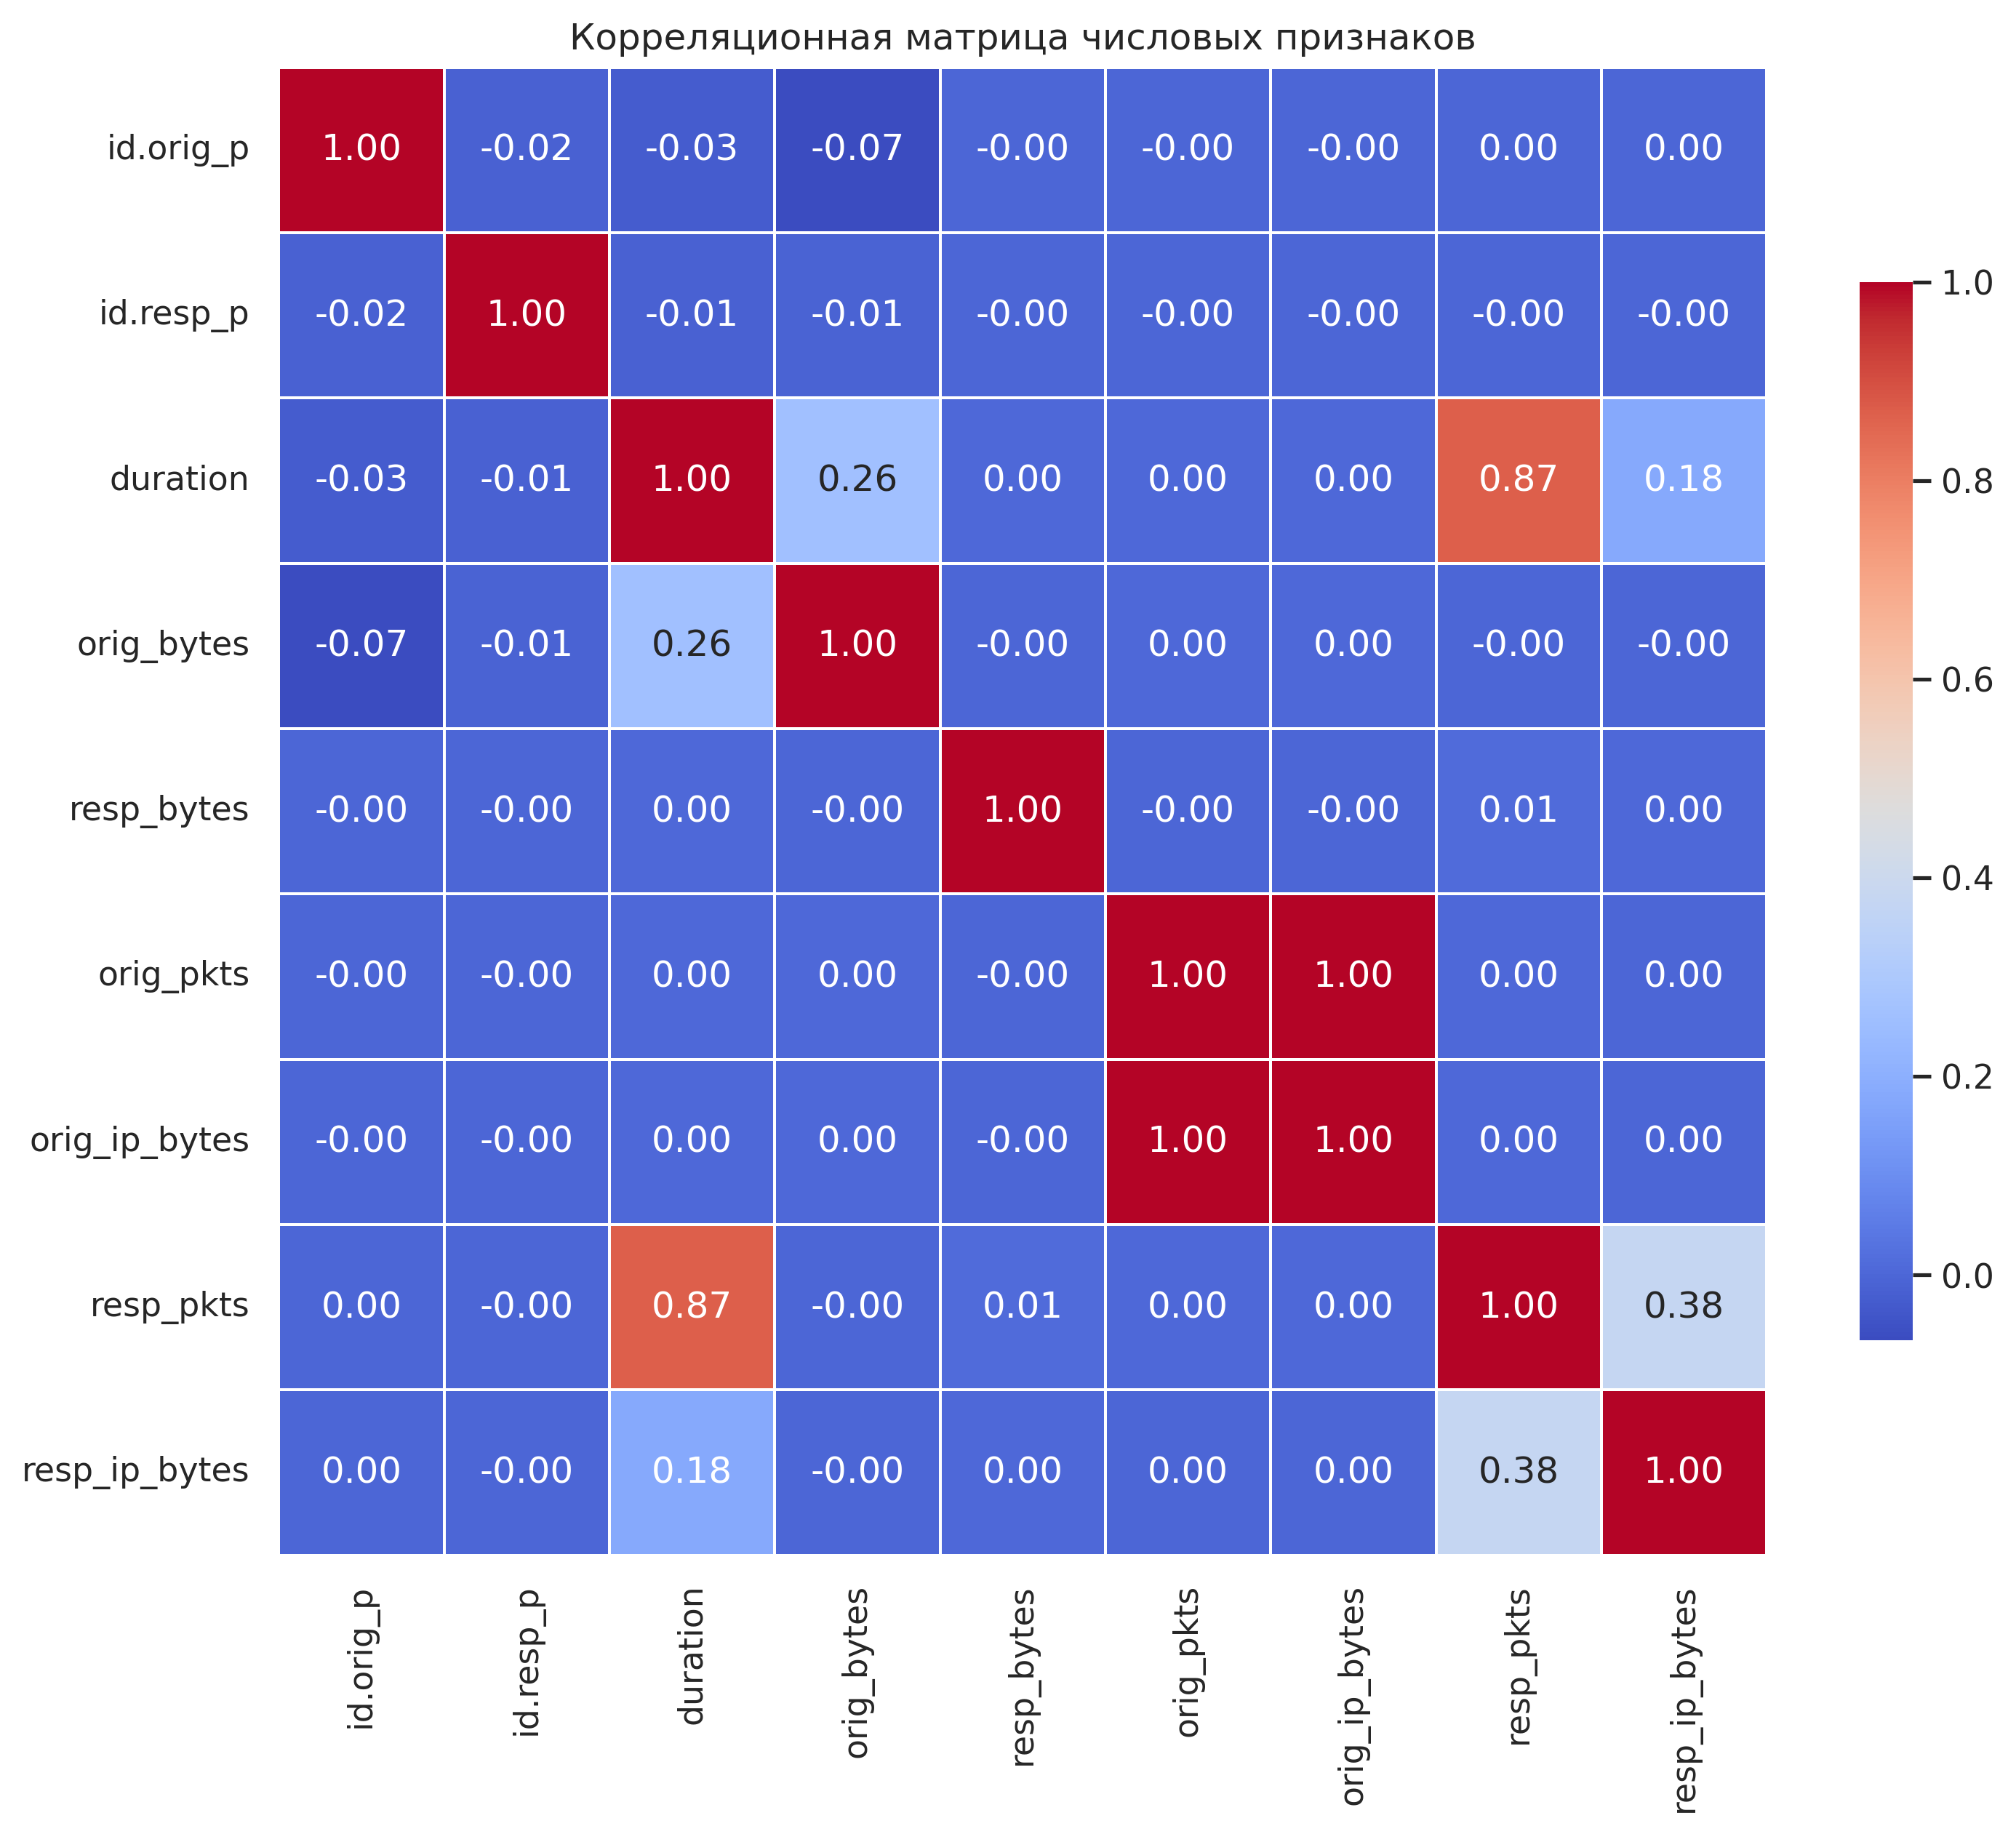

In [19]:
corr = df_copy[numeric_cols].corr(method="pearson")

sns.set_theme(style="whitegrid", context="notebook")

plt.figure(figsize=(11, 9))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=.5,
    cbar_kws={"shrink": .7},
    square=True
)

plt.title("Корреляционная матрица числовых признаков")
plt.show()

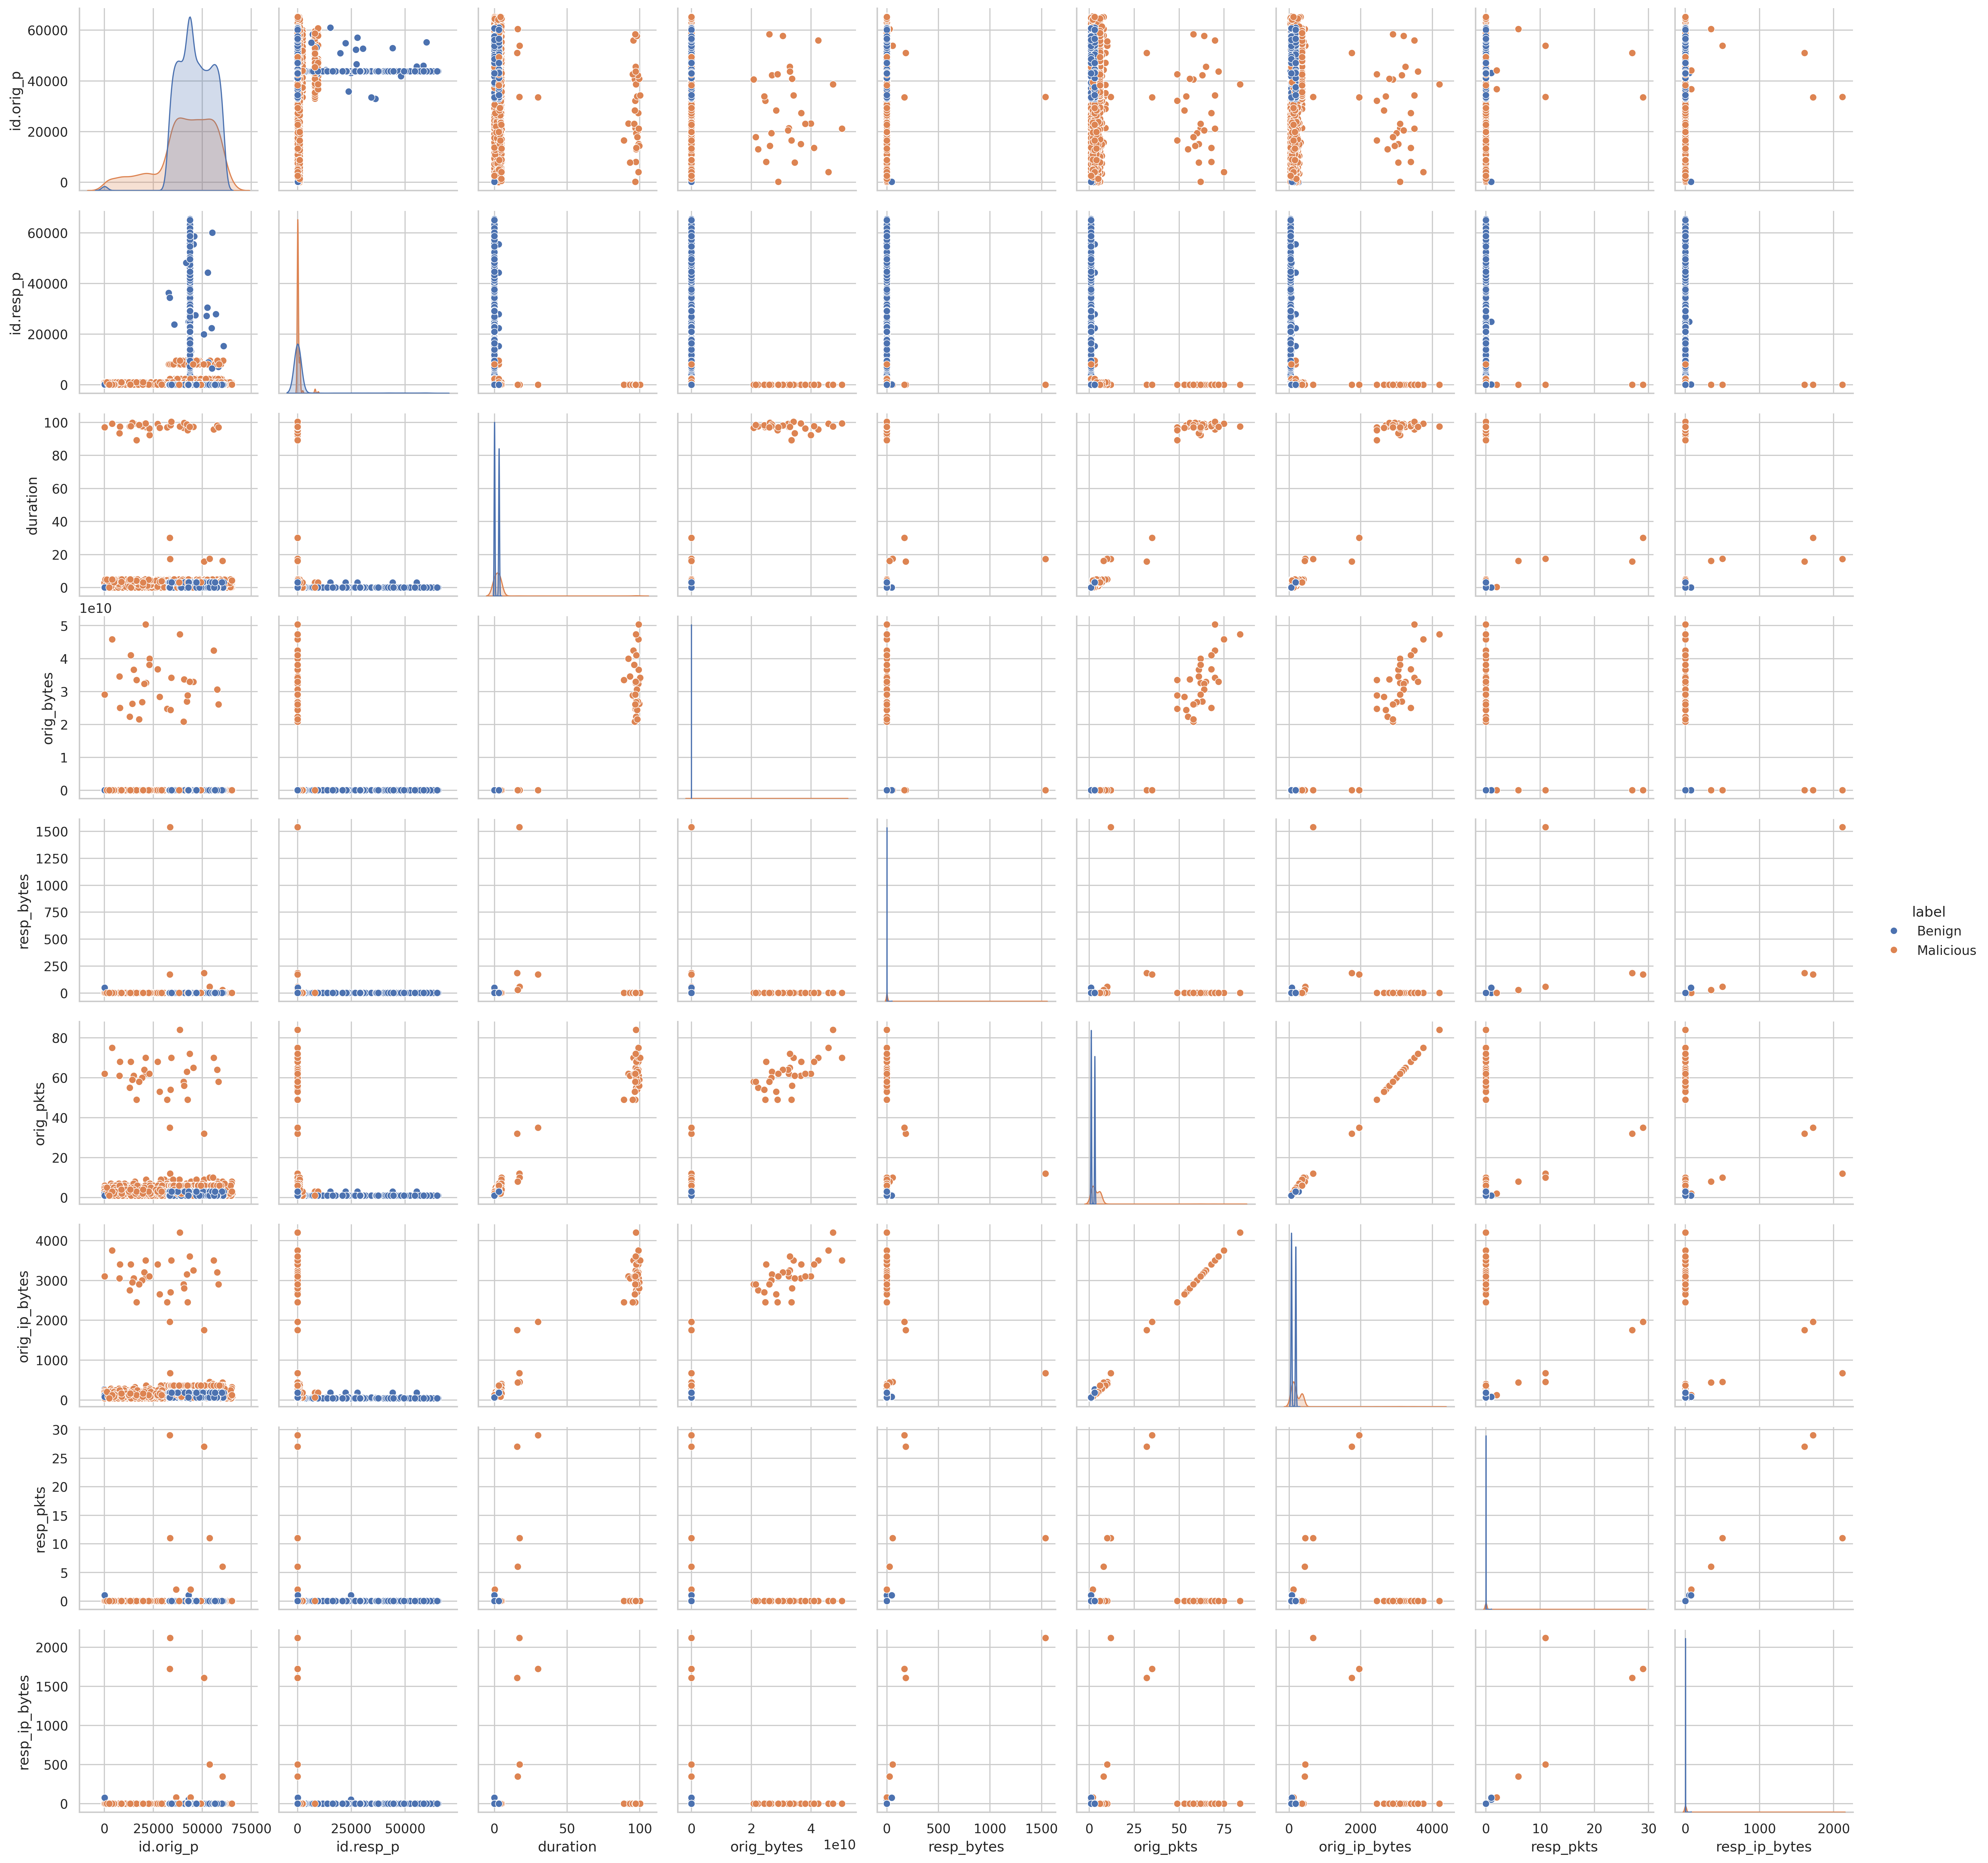

In [20]:
size_sample = 8000
random_state = 42

pair_df = df_copy.sample(n=size_sample, random_state=random_state)

sns.pairplot(
    pair_df,
    vars=numeric_cols,
    hue="label",
)

plt.show()

#### Выводы

* Баланс классов умеренный (но с метриками всё равно надо быть аккуратнее).
* По `proto` тяжело что-то сказать, а вот в `service`, `conn_state` и `history` много практически на 100% злонамеренных категорий, которые почти сразу можно брать за правило.
* Признаки `orig_pkts` и `orig_ip_bytes` фактически дублируют друг друга (поэтому, можно было бы оставить только один).
* Остальные числовые признаки практически не коррелируют, поэтому деревьям/градиентым бустингам будет хорошо.